In [190]:
%matplotlib inline

### Shamelessly ripped off from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html



# Feature importances with ~~a forest of trees~~ *pretty much any regressor*

This example shows the use of ~~a forest of trees~~ *pretty much any regressor*
to evaluate the importance of
features on an artificial classification task. The blue bars are the feature
importances of the forest, along with their inter-trees variability represented
by the error bars.

As expected, the plot suggests that 3 features are informative, while the
remaining are not.

In [191]:
import matplotlib.pyplot as plt

## Data generation and model fitting
We generate a synthetic dataset with only 3 informative features. We will
explicitly not shuffle the dataset to ensure that the informative features
will correspond to the three first columns of X. In addition, we will split
our dataset into training and testing subsets.



In [192]:
from sklearn.datasets import make_classification, make_regression, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn import set_config
import pandas as pd
import sklearn
try:
    set_config(display="diagram")
except Exception:
    print("I can't display pipelines as diagram because sklearn 0.23+ isn't installed :'(")

#X, y = make_classification(
#    n_samples=1000,
#    n_features=10,
#    n_informative=3,
#    n_redundant=0,
#    n_repeated=0,
#    n_classes=2,
#    random_state=0,
#    shuffle=False,
#)

X, y = make_regression(
    n_samples=1000,
    n_features = 20,
    n_informative=9,
    effective_rank=10,
    random_state=42,
    shuffle=True,
    noise=0.2
)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

A random forest classifier will be fitted to compute the feature importances.



In [193]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor

from sklearn.linear_model import ARDRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

feature_names = [f"feature {i}" for i in range(X.shape[1])]

fpipeline = Pipeline(
    steps=[
        ("scaler",QuantileTransformer()),
        #("learner",RandomForestRegressor())
        #("learner",ARDRegression())
        #("learner",AdaBoostRegressor(base_estimator=RandomForestRegressor()))
        ("learner",AdaBoostRegressor(base_estimator=ARDRegression()))
        #("learner",LinearRegression())
    ]
)
learner = fpipeline["learner"]
fpipeline.fit(X_train, y_train)

print(fpipeline.score(X_test,y_test))

0.9539465031729216


D:\PycharmProjects\ce888\venv38\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (750). n_quantiles is set to n_samples.
  warnings.warn(


## Feature importance based on mean decrease in impurity
Feature importances are provided by the fitted attribute
`feature_importances_` and they are computed as the mean and standard
deviation of accumulation of the impurity decrease within each tree.

<div class="alert alert-danger"><h4>Warning</h4><p>Impurity-based feature importances can be misleading for **high
    cardinality** features (many unique values). See
    `permutation_importance` as an alternative below.</p></div>



In [194]:
import time
import numpy as np


start_time = time.time()

def get_importances(predictor):
    
    try:
        return predictor.feature_importances_
    except AttributeError as e1:
        print(e1)
        try:
            return predictor.coef_.flatten()
        except AttributeError as e2:
            print(e2)
            return np.mean([get_importances(p) for p in predictor.estimators_],axis=0)
    
    
def get_importance_std(predictor):
    
    try:
        return np.std([get_importances(p) for p in predictor.estimators_],axis=0)
    except AttributeError as e3:
        print(e3)
        return np.std([get_importances(predictor)],axis=0)

importances = get_importances(learner)

print(importances.shape)

std = get_importance_std(learner)

print(std)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute
'AdaBoostRegressor' object has no attribute 'coef_'
'ARDRegression' object has no attribute 'feature_importances_'
'ARDRegression' object has no attribute 'feature_importances_'
'ARDRegression' object has no attribute 'feature_importances_'
'ARDRegression' object has no attribute 'feature_importances_'
'ARDRegression' object has no attribute 'feature_importances_'
'ARDRegression' object has no attribute 'feature_importances_'
'ARDRegression' object has no attribute 'feature_importances_'
'ARDRegression' object has no attribute 'feature_importances_'
'ARDRegression' object has no attribute 'feature_importances_'
'ARDRegression' object has no attribute 'feature_importances_'
'ARDRegression' object has no attribute 'feature_importances_'
(20,)
'ARDRegression' object has no attribute 'feature_importances_'
'ARDRegression' object has no attribute 'feature_importances_'
'ARDRegression' o

Let's plot the impurity-based importance.



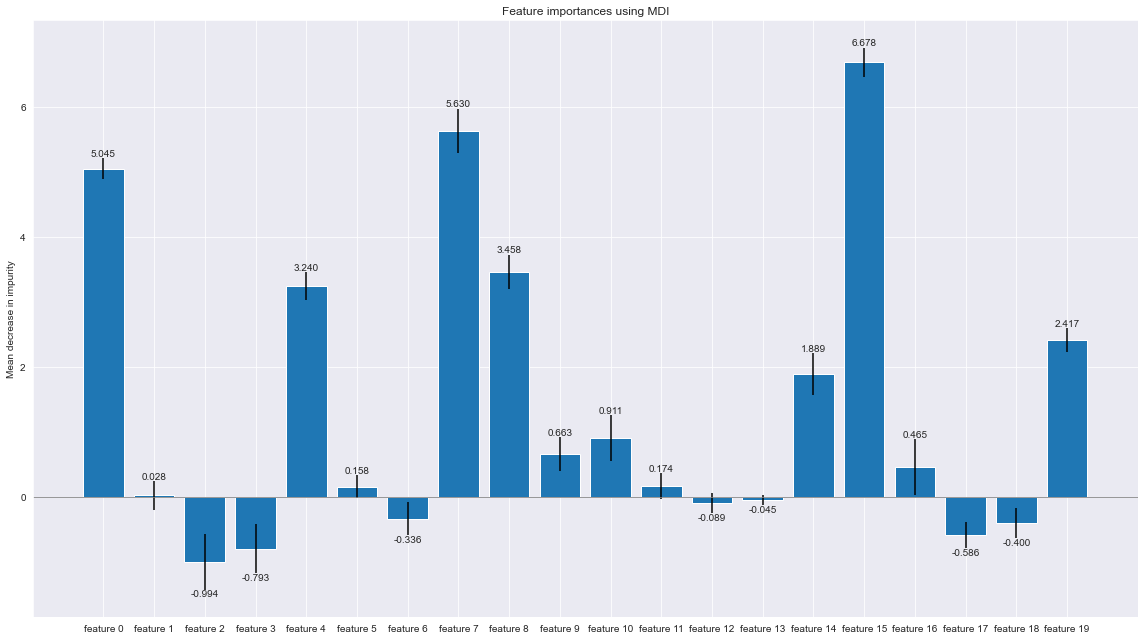

In [195]:
import pandas as pd

learner_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(
    figsize=(16,9)
)
bar = ax.bar(
    feature_names,
    #learner_importances.index,
    importances,
    #learner_importances.values,
    #0.35,
    yerr=std
)

ax.bar_label(bar, fmt='%.3f')

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()



## Feature importance based on feature permutation
Permutation feature importance overcomes limitations of the impurity-based
feature importance: they do not have a bias toward high-cardinality features
and can be computed on a left-out test set.



In [196]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    learner, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

learner_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 1.195 seconds


The computation for full permutation importance is more costly. Features are
shuffled n times and the model refitted to estimate the importance of it.
Please see `permutation_importance` for more details. We can now plot
the importance ranking.



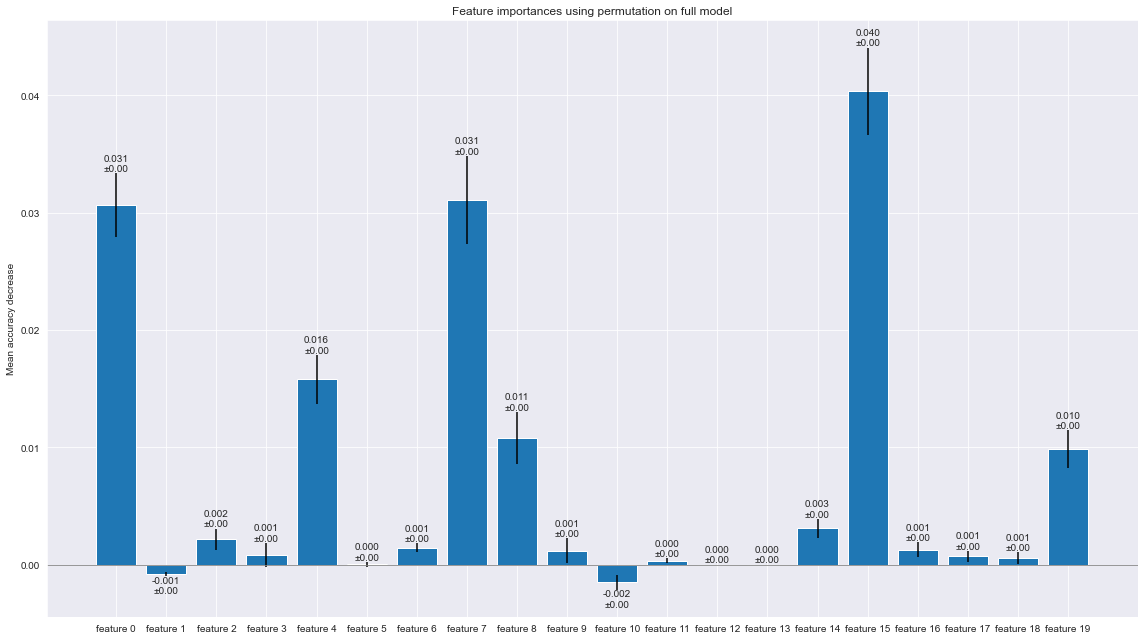

In [197]:
fig, ax = plt.subplots(
    figsize=(16,9)
)

bar = ax.bar(
    learner_importances.index,
    learner_importances.values,
    #0.35,
    yerr=result.importances_std
)
ax.bar_label(
    bar,
    #label_type="center",
    labels=[
        f'{val:.3f}\n±{err:.2f}'
        for val, err in zip(learner_importances.values, result.importances_std)
    ]
)
    #fmt='%.3f')

ax.axhline(0, color='grey', linewidth=0.8)

#learner_importances.plot.bar(yerr=result.importances_std, ax=ax)
#for container in ax.containers:
#    ax.bar_label(container, label_type="center")
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
ax.grid(visible=True, which="both", axis="both")
fig.tight_layout()
plt.show()

The same features are detected as most important using both methods. Although
the relative importances vary. As seen on the plots, MDI is less likely than
permutation importance to fully omit a feature.

